In [2]:
import ast

import copy

import os

from typing import List, Tuple

import numpy as np
import pandas as pd 

from scipy.stats import kruskal

from sklearn.metrics import f1_score, confusion_matrix

from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_dir = "/home/ksasse/code/fairness/output/used_results/"

models = [
    "10shot_ul2",
    "10shot_flan_ul2",
    "10shot_llama_13b",
    "10shot_llama_65b",
    "10shot_alpaca_13b",
    "10shot_alpaca_7b"
]

protected_att = [
    "10shot_protected_category_ul2",
    "10shot_matrix_protected_category_prompts_flanul2",
    "10shot_protected_category_llama_13b",
    "10shot_protected_category_llama_65b",
    "10shot_protected_category_alpaca_13b",
    "10shot_protected_category_alpaca_7b",
]


resamples = 100

In [5]:
def open_and_clean_file(file: str) -> Tuple[List[int], List[int], List[int]]:

    overall_demographics =  {"aae": ['aa', 'wh'], "hatexplain-race": ["African", "Arab", "Asian", "Hispanic", "Caucasian"], "bias": ["m", "f"]}
    labels_map = {"aae" : {"happy": 1, "sad": 0, "fail________" : -1}, "hatexplain-race": {"yes" : 1, "no" : 0, "fail________" : -1}, "bias" : {"attorney": 0, "photographer": 1, "dentist" : 2, "psychologist" : 3, "physician": 4, "journalist" : 5, "teacher": 6, "professor": 7, "fail________" : -1}}

    results = pd.read_csv(file)

    if "flan" not in file and "ul2" not in file and "gpt" not in file:
        results['prompt_len'] = results.prompt.str.len()
        results['response'] = results.apply(lambda x: x.response[x.prompt_len:], axis=1)

    responses = results['response'].fillna("").tolist()
    labels = results['label'].tolist()

    demographics = [ast.literal_eval(x) for x in results['demographic'].tolist()]

    model_name, dataset, demonstration = os.path.basename(file).split("_")
    demonstration = demonstration[:-4]

    dataset_overall_demographics = overall_demographics[dataset]

    responses = [x.lower() for x in responses]

    conv = lambda i: i or ""
    responses = [conv(i) for i in responses]

    if dataset == "bias":
        responses = [x.replace("lawyer", "attorney") for x in responses]

    # map labels to numbers to make it easier for sklearn calculations
    labels_dict = labels_map[dataset]

    labels_set = list(labels_dict.keys())

    # map the labels lists to dummy labels
    dummy_labels = [labels_dict[x] for x in labels]

    dummy_preds = []

    for pred in responses:
        # see if any of the labels are in the response
        for label in labels_set:
            if pred.find(label) != -1:
                dummy_preds.append(labels_dict[label])
                break
            # if not we add -1 instead
        else:
            dummy_preds.append(-1)

    dummy_preds = np.array(dummy_preds)
    dummy_labels = np.array(dummy_labels)

    demographic_index = [
        i
        for i, item in enumerate(demographics)
        if len(set(dataset_overall_demographics).intersection(set(item))) != 0
    ]

    dummy_preds = dummy_preds[demographic_index]
    dummy_labels = dummy_labels[demographic_index]

    demographics_filtered = copy.deepcopy([demographics[i] for i in demographic_index])

    return dummy_preds, dummy_labels, demographics_filtered, dataset_overall_demographics, labels_dict
    

# Experiment Results

In [15]:
# folders = [os.path.join(data_dir, x) for x in os.listdir(data_dir)]

import csv
from sklearn.metrics import recall_score
from tqdm import tqdm
import pdb

normal = [os.path.join(data_dir, x) for x in models]
protected = [os.path.join(data_dir, x) for x in protected_att]
with open("protected_results.csv","w",) as csvfile:
    csvwriter = csv.writer(csvfile)
    for protected, f_folders in zip(["no change", "protected"], [normal, protected]):
        for folder in f_folders:
            print(f"doing {os.path.basename(folder)}")
            files = [os.path.join(folder, x) for x in os.listdir(folder) if x.find(".csv") != -1]

            for file in tqdm(files):
                model_name, dataset, demonstration = os.path.basename(file).split("_")
                demonstration = demonstration[:-4]
                if demonstration not in ["zeroshot", "random", "similarity", "diversity", "within", "stratified"]:
                    continue

                dummy_preds, dummy_labels, demographics_filtered, dataset_overall_demographics, labels_dict = open_and_clean_file(file)

                shots = 10 if demonstration != "zeroshot" else 0

                scores = []
                f1 = np.mean(f1_score(dummy_preds, dummy_labels, average=None, labels=list(labels_dict.values()))[:-1])
                for dem in dataset_overall_demographics:
                    index = [i for i, item in enumerate(demographics_filtered) if dem in item]
                    preds = dummy_preds[index]
                    labels = dummy_labels[index]
                    recall = recall_score(labels, preds, labels=list(labels_dict.values()), average=None)

                    if dataset == "aae" or dataset == "hatexplain-race":
                        recall = recall[0]
                        if np.isnan(recall):
                            recall = 0  
                    else:
                        recall = np.min(recall[:-1])
                        if np.isnan(recall):
                            recall = 0  

                    scores.append(recall)
                gap = np.max(scores) - np.min(scores)
                csvwriter.writerow([model_name, dataset, shots, protected, demonstration, f1, 1-gap])

doing 10shot_ul2


100%|█████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.42it/s]


doing 10shot_flan_ul2


100%|█████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  6.64it/s]


doing 10shot_llama_13b


100%|█████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.41it/s]


doing 10shot_llama_65b


100%|█████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.40it/s]


doing 10shot_alpaca_13b


100%|█████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.35it/s]


doing 10shot_alpaca_7b


100%|█████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.36it/s]


doing 10shot_protected_category_ul2


100%|█████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  6.00it/s]


doing 10shot_matrix_protected_category_prompts_flanul2


100%|█████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.98it/s]


doing 10shot_protected_category_llama_13b


100%|█████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.17it/s]


doing 10shot_protected_category_llama_65b


100%|█████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.18it/s]


doing 10shot_protected_category_alpaca_13b


100%|█████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.15it/s]


doing 10shot_protected_category_alpaca_7b


100%|█████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.12it/s]


# Running Specific models

In [115]:
def get_stats(file):
    dummy_preds, dummy_labels, demographics_filtered, dataset_overall_demographics, labels_dict = open_and_clean_file(file)

    model_name, dataset, demonstration = os.path.basename(file).split("_")
    demonstration = demonstration[:-4]

    shots = 10 if demonstration != "zeroshot" else 0

    demographic_samples = []
    for i in range(100):
        sample_index = np.random.choice(len(dummy_preds), size=len(dummy_preds), replace=True)
        sample_demographics = np.array(demographics_filtered)[sample_index]
        sample_preds = dummy_preds[sample_index]
        sample_labels = dummy_labels[sample_index]
        scores = []
        for dem in dataset_overall_demographics:
            index = [i for i, item in enumerate(sample_demographics) if dem in item]
            preds = sample_preds[index]
            labels = sample_labels[index]
            recall = recall_score(labels, preds, labels=list(labels_dict.values()), average=None)
            if dataset == "aae" or dataset == "hatexplain-race":
                recall = recall[0]
                if np.isnan(recall):
                    recall = 0  
            else:

                recall = np.min(recall[:-1])

                if np.isnan(recall):
                    recall = 0  

            scores.append(recall)

        demographic_samples.append(scores)
    all_recalls = np.array(demographic_samples)
    try:
        if dataset == "aae" or dataset == "hatexplain-race":
            kl = kruskal(all_recalls[:, 0], all_recalls[:, 1])
        else:
            kl = kruskal(all_recalls[:, 0], all_recalls[:, 1], all_recalls[:, 2], all_recalls[:, 3], all_recalls[:, 4])
        statistic = kl.statistic
        pvalue = kl.pvalue
        if pvalue < .05:
            result = "unfair"
        else:
            result = "fair"
    except ValueError:
        statistic = 0 
        pvalue = 1.0
        result = "fair"
    return statistic, pvalue, result

In [116]:
file = "/home/ksasse/code/fairness/output/used_results/10shot_gpt_3/gpt3_aae_similarity.csv"

dummy_preds, dummy_labels, demographics_filtered, dataset_overall_demographics, labels_dict = open_and_clean_file(file)
print(f"F1: {np.mean(f1_score(dummy_preds, dummy_labels, average=None, labels=list(labels_dict.values()))[:-1])}")
for dem in dataset_overall_demographics:
    index = [i for i, item in enumerate(demographics_filtered) if dem in item]
    preds = dummy_preds[index]
    labels = dummy_labels[index]
    recall = recall_score(labels, preds, labels=list(labels_dict.values()), average=None)
    print(f"{dem}: {recall}")

stats, pvalue, result = get_stats(file)
print(f"stats: {stats}\npvalue: {pvalue}\n{result}")

F1: 0.7105823350488609
aa: [0.673 0.673 0.   ]
wh: [0.668  0.7895 0.    ]
stats: 14.979483745544902
pvalue: 0.00010868643186861213
unfair


# Checking Results

In [8]:
results = pd.read_csv("protected_results.csv", header=None, 
                      names=['model', 'data', 'shots', "protected",'selection method', 'f1', '1-GAP'])
results['model'] = results.model.apply(lambda model: "ul2" if model == "offline-ul2" else model)

In [9]:
def custom_sorting(col):
    if col.name == 'model':
        models = ['gpt3', 'chatgpt', 'ul2', "flan-ul2", 'llama-13b', 'llama-65b', 'alpaca-7b', 'alpaca-13b']
        return col.apply(lambda d: models.index(d))
    elif col.name == 'data':
        data = ['hatexplain-race', 'bias', 'aae']
        return col.apply(lambda d: data.index(d))
    elif col.name == 'protected':
        prot = ['no change', 'protected']
        return col.apply(lambda d: prot.index(d))
    else:
        methods = ['zeroshot', 'random', 'similarity',"diversity",'within','stratified']
        return col.apply(lambda d: methods.index(d))

In [10]:
results = results.sort_values(["data", "model", "selection method", "protected"], key=custom_sorting)

In [23]:
results.to_csv("protected_results_ordered.csv", index=False)

In [11]:
normal = results[results.protected != 'protected']
protected = results[results.protected == 'protected']

f1_diff = protected.f1.values - normal.f1.values
gap_diff = protected['1-GAP'].values - normal['1-GAP'].values

difference = normal[['data', 'model', 'selection method']]
difference['f1'] = f1_diff
difference['1-GAP'] = gap_diff

## Making the plot

In [12]:
base_df = difference[difference.data=='bias']
sf = base_df[(base_df['selection method']=='zeroshot')|
        (((base_df.model=='ul2')&(base_df['selection method']=='similarity'))|
         ((base_df.model=='flan-ul2')&(base_df['selection method']=='diversity'))|
         ((base_df.model=='llama-13b')&(base_df['selection method']=='similarity'))|
         ((base_df.model=='llama-65b')&(base_df['selection method']=='diversity'))|
         ((base_df.model=='alpaca-7b')&(base_df['selection method']=='similarity'))|
         ((base_df.model=='alpaca-13b')&(base_df['selection method']=='diversity')))]
bf = base_df[base_df['selection method'].isin(['zeroshot', 'similarity', 'diversity'])]

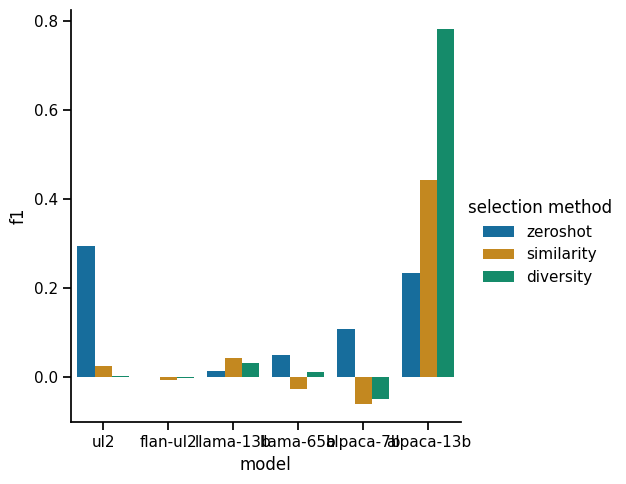

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook")

f=sns.catplot(data=bf, x="model", y="f1", hue="selection method", 
            kind="bar",
            hue_order=[ 'zeroshot', 'similarity', 'diversity'],
           palette='colorblind')
f.savefig("../results/figs/demographic_prompt_f1.pdf")

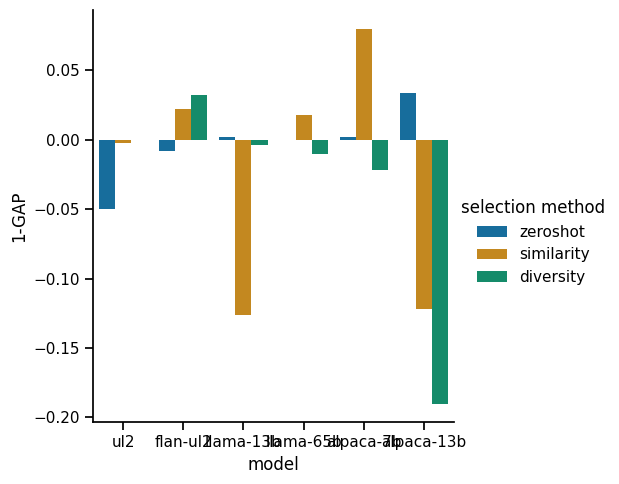

In [28]:
sns.set_context("notebook")
f=sns.catplot(data=bf, x="model", y="1-GAP", hue="selection method", 
            kind="bar",
            hue_order=[ 'zeroshot', 'similarity', 'diversity'], palette='colorblind')
f.savefig("../results/figs/demographic_prompt_gap.pdf")

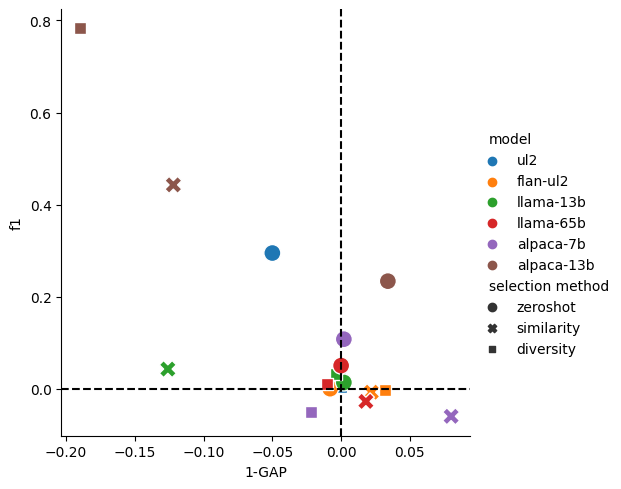

In [16]:
sns.relplot(data=bf, x="1-GAP", y="f1", style="selection method", hue='model', 
            kind="scatter",  s=150,
           style_order=[ 'zeroshot', 'similarity', 'diversity'])
# adding vertical line in data co-ordinates
plt.axvline(0, c='black', ls='--')
  
# adding horizontal line in data co-ordinates
plt.axhline(0, c='black', ls='--')

# Getting Random Baselines

### AAE

In [206]:
file = "/home/ksasse/code/fairness/output/used_results/10shot_gpt_3/gpt3_aae_similarity.csv"

dummy_preds, dummy_labels, demographics_filtered, dataset_overall_demographics, labels_dict = open_and_clean_file(file)
rands = np.random.choice([0, 1], size=len(dummy_labels))
f1s = []
for _ in range(1000):
    rands = np.random.choice([0, 1], size=len(dummy_labels))
    f1s.append(f1_score(dummy_labels, rands))
print(f"random F1: {np.mean(f1s)}")
print(f"major  F1: {np.mean(f1_score(dummy_labels, np.ones(len(dummy_labels))))}")

random F1: 0.5001681499827405
major  F1: 0.6666666666666666


In [213]:
file = "/home/ksasse/code/fairness/output/used_results/10shot_gpt_3/gpt3_aae_similarity.csv"

dummy_preds, dummy_labels, demographics_filtered, dataset_overall_demographics, labels_dict = open_and_clean_file(file)
len(dummy_labels)

8000

### hatexplain-race

In [207]:
file = "/home/ksasse/code/fairness/output/used_results/10shot_gpt_3/gpt3_hatexplain-race_similarity.csv"

dummy_preds, dummy_labels, demographics_filtered, dataset_overall_demographics, labels_dict = open_and_clean_file(file)
np.unique(dummy_labels, return_counts=True)

(array([0, 1]), array([137, 537]))

In [209]:
f1s = []
for _ in range(1000):
    rands = np.random.choice([0, 1], size=len(dummy_labels))
    f1s.append(f1_score(dummy_labels, rands))
print(f"F1: {np.mean(f1s)}")
print(f"major  F1: {np.mean(f1_score(dummy_labels, np.ones(len(dummy_labels))))}")

F1: 0.6129650516749162
major  F1: 0.8868703550784476


### Bias

In [214]:
file = "/home/ksasse/code/fairness/output/used_results/10shot_gpt_3/gpt3_bias_similarity.csv"

dummy_preds, dummy_labels, demographics_filtered, dataset_overall_demographics, labels_dict = open_and_clean_file(file)
np.unique(dummy_labels, return_counts=True)
len(dummy_labels)

8000

In [212]:
f1s = []
for _ in range(1000):
    rands = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7], size=len(dummy_labels))
    f1s.append(f1_score(dummy_labels, rands, average='macro'))
print(f"F1: {np.mean(f1s)}")
print(f"major  F1: {np.mean(f1_score(dummy_labels, np.ones(len(dummy_labels)), average='macro'))}")

F1: 0.12483869849703508
major  F1: 0.027777777777777776
